### Defaulting to older opencv to use older sift

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

## Importing some of the required libraries

In [ ]:
import os
import cv2
from tqdm import tqdm
import numpy as np
import sklearn.cluster
import pickle

In [ ]:
!unzip /content/drive/MyDrive/SUN_data.zip

Archive:  /content/drive/MyDrive/SUN_data.zip
replace __MACOSX/._SUN_data? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Loading the dataset

In [ ]:
train_ims = {}
test_ims = {}

comps = [ f.name for f in os.scandir("/content/SUN_data/test") if f.is_dir() ]
print(comps)
tot_test = []
for comp in comps:
    train_ims[comp] = []
    test_ims[comp] = []
    for fname in os.listdir(os.path.join("/content/SUN_data/test",comp)):
        # print(fname)
        if fname.lower().endswith('.jpg'):
            im = cv2.cvtColor(cv2.imread(os.path.join("/content/SUN_data/test",comp,fname)),cv2.COLOR_BGR2GRAY)
            # im = cv2.resize(im,(150,150))
            test_ims[comp].append(im)
            tot_test.append(im)

    for fname in os.listdir(os.path.join("/content/SUN_data/train",comp)):
        # print(fname)
        if fname.lower().endswith('.jpg'):
            im = cv2.cvtColor(cv2.imread(os.path.join("/content/SUN_data/train",comp,fname)),cv2.COLOR_BGR2GRAY)
            # im = cv2.resize(im,(150,150))
            train_ims[comp].append(im)




['kitchen', 'laundromat', 'waterfall', 'windmill', 'park', 'highway', 'aquarium', 'desert']


## Extracting features using sift

In [ ]:
def extract_features(img_dict):
    sift = cv2.xfeatures2d.SIFT_create()
    desc_list = []
    sift_vector = {}
    for category,images in tqdm(img_dict.items()):
        feats = []
        for im in images:
            kp,des = sift.detectAndCompute(im,None)
            desc_list.extend(des)
            feats.append(des)

        sift_vector[category] = feats
    
    return sift_vector,desc_list


In [ ]:
train_sift , train_dict = extract_features(train_ims)
test_sift , test_dict = extract_features(test_ims)

100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


In [ ]:
train_feat_list = np.asarray(train_dict,dtype=np.float32)
test_feat_list = np.asarray(test_dict,dtype=np.float32)

## Kmeans Clustering

In [ ]:
kmeans = sklearn.cluster.KMeans(n_clusters = 100).fit(train_feat_list)

#### Saving models

In [ ]:
pickle.dump(kmeans, open("/content/drive/MyDrive/model_100.pkl", "wb"))
# pickle.dump([train_sift,train_dict,test_sift,test_dict],open("/content/drive/MyDrive/sift.pkl","wb"))

Getting histograms from clustered outputs

In [ ]:
def get_histograms(sift_vector,kmeans,norm):
    histograms = []
    labels = []
    for category,desc_list in sift_vector.items():
        for des in desc_list:
            hist = np.zeros(kmeans.n_clusters)
            meta = np.asarray(kmeans.predict(des),dtype=np.int64)
            for i in meta:
                hist[i] += 1
            if norm : hist = (hist * 1.0)/np.sum(hist)
            histograms.append(hist)
            labels.append(comps.index(category))
    return np.array(histograms),np.array(labels)


In [ ]:
def load(filename):
    with open(filename, 'rb') as f: return pickle.load(f)

In [ ]:
# print(test_hists.shape)
kmeans_70 = load("/content/drive/MyDrive/model.pkl")
kmeans_50 = load("/content/drive/MyDrive/model_50.pkl")
kmeans_100 = load("/content/drive/MyDrive/model_100.pkl")
kmeans_200 = load("/content/drive/MyDrive/model_200.pkl")



In [ ]:
train_hists,train_labels = get_histograms(train_sift,kmeans_200,True)
test_hists,test_labels = get_histograms(test_sift,kmeans_200,True)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC()).fit(train_hists, train_labels)
yhat = clf.predict(test_hists)

## For kmeans with 200 clusters with normalized histograms

In [ ]:
from sklearn import metrics   
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(test_labels, yhat)
print(confusion_matrix)
print("Accuracy Score:", np.trace(confusion_matrix) / len(yhat))

Confusion Matrix:
[[15  2  0  0  1  0  2  0]
 [10  8  0  0  0  2  0  0]
 [ 0  0 10  0  8  1  1  0]
 [ 0  0  0  4  8  1  1  6]
 [ 0  0  1  0 17  1  1  0]
 [ 3  3  3  0  2  7  0  2]
 [ 0  0  2  0  0  0 18  0]
 [ 0  0  3  0  1  2  1 13]]
Accuracy Score: 0.575


In [ ]:
def dynamic_plotting(imglist, rows, cols, title=None):
    plt.figure(figsize=(12, 12))
    idx=1
    if title is None:
        title = [i for i in range(0, rows*cols)]
    for i in range(1, rows+1):
        for j in range(1, cols+1):
            img = imglist[idx-1].astype('uint8')
            # image.astype('uint8')
            plt.subplot(rows, cols, idx)
            plt.imshow(img,cmap='gray')
            plt.title(title[idx-1])
            idx+=1
            plt.axis('off')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
def plotter(kmeans,norm):
    train_hists,train_labels = get_histograms(train_sift,kmeans,norm)
    test_hists,test_labels = get_histograms(test_sift,kmeans,norm)
    clf = OneVsRestClassifier(SVC()).fit(train_hists, train_labels)
    yhat = clf.predict(test_hists)
    idx = np.where(test_labels == yhat)[0]
    nidx = np.where(test_labels != yhat)[0]
    l = len(idx)
    nl = len(nidx)
    nrndid = np.random.randint(0,nl,2)
    rndid = np.random.randint(0,l,2)
    titles = []
    # print(idx[rndid])
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(test_labels, yhat)
    print(confusion_matrix)
    print("Accuracy Score:", np.trace(confusion_matrix) / len(yhat))
    images = []
    for id in idx[rndid]:
        images.append(tot_test[id])
        titles.append("actual:" + comps[test_labels[id]] + "  guessed:" + comps[yhat[id]])
    for id in nidx[nrndid]:
        images.append(tot_test[id])
        titles.append("actual:" + comps[test_labels[id]] + "  guessed:" + comps[yhat[id]])
    # print(len(images))
    # plt.imshow(images[1])
    dynamic_plotting(images,2,2,titles)


# plt.imshow(tot_test[39])

### kmeans with 100 clusters with normalization

Confusion Matrix:
[[15  3  0  0  0  0  2  0]
 [13  7  0  0  0  0  0  0]
 [ 0  0 10  0  7  1  2  0]
 [ 0  1  1  3  8  2  0  5]
 [ 0  0  1  0 18  0  1  0]
 [ 4  4  1  0  2  5  0  4]
 [ 0  0  2  0  0  0 17  1]
 [ 0  0  2  1  0  2  1 14]]
Accuracy Score: 0.55625


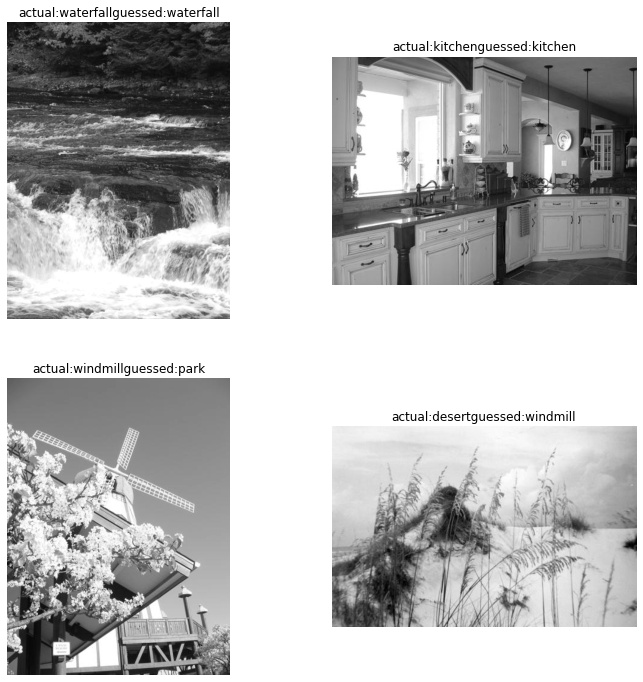

In [ ]:
plotter(kmeans_100,True)
# plt.imshow(images)

### For kmeans with 50 clusters and normalized histograms

Confusion Matrix:
[[14  4  1  0  0  0  1  0]
 [ 8 11  0  0  0  1  0  0]
 [ 0  0 10  0  7  0  3  0]
 [ 0  1  1  1  9  1  0  7]
 [ 0  0  1  0 17  1  1  0]
 [ 0  4  3  0  2  9  0  2]
 [ 0  0  1  0  0  0 17  2]
 [ 0  0  2  0  0  2  1 15]]
Accuracy Score: 0.5875


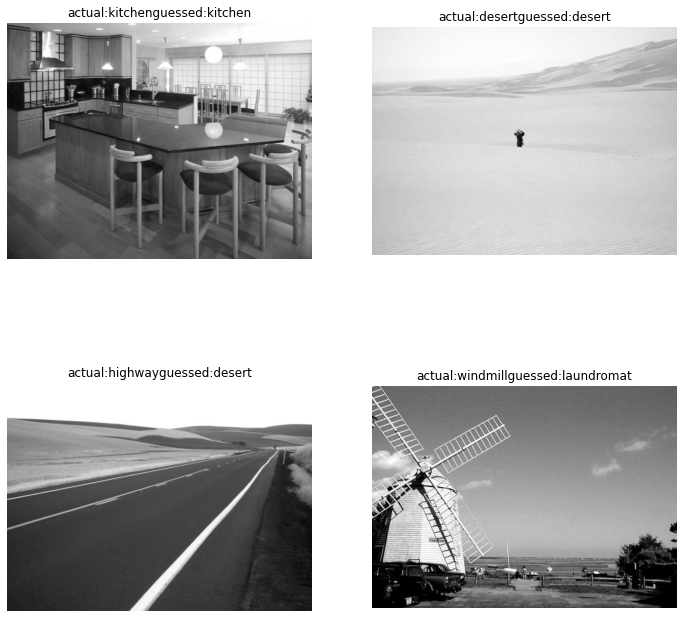

In [ ]:
plotter(kmeans_50,True)

### For kmeans with 70 clusters histograms without normalization

Confusion Matrix:
[[16  1  0  0  1  0  2  0]
 [10  8  1  0  0  0  1  0]
 [ 0  0  7  0 10  1  2  0]
 [ 1  0  1  5  5  2  0  6]
 [ 0  0  3  1 12  2  2  0]
 [ 1  3  2  0  2 10  0  2]
 [ 1  0  0  0  1  0 17  1]
 [ 0  0  3  0  1  2  0 14]]
Accuracy Score: 0.55625


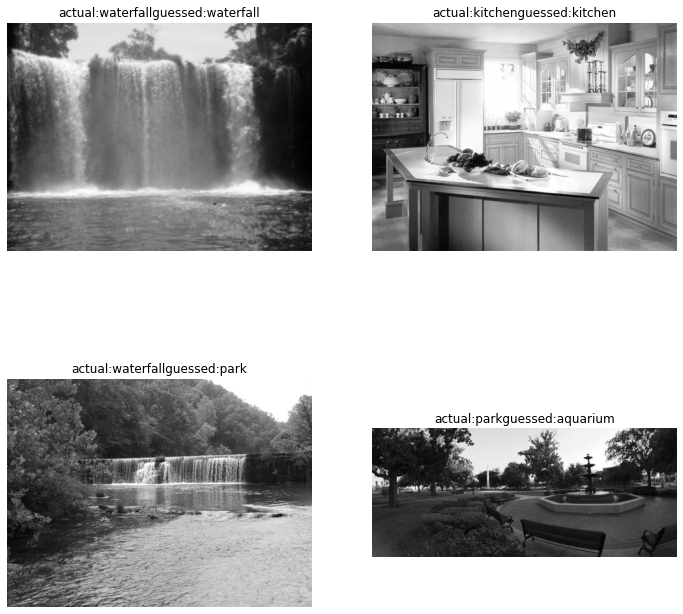

In [ ]:
plotter(kmeans_70,False)